<a href="https://colab.research.google.com/github/ariG23498/NeuralStyleTransfer/blob/master/Aritra_NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports
The imports that have been used:
1. tensorflow
2. IPython.display
3. numpy
4. matplotlib
5. tqdm

In [1]:
import tensorflow as tf
from IPython.display import display, Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Data
* Visualize the data
* Pre-process the data

In [119]:
content_path = tf.keras.utils.get_file(
    "paris.jpg",
    "https://i.imgur.com/F28w3Ac.jpg")

style_path = tf.keras.utils.get_file(
    "starry_night.jpg",
    "https://i.imgur.com/9ooB60I.jpg")

print('Content Path: {}'.format(content_path))
print('Style Path: {}'.format(style_path))

942080/935806 [==============================] - 0s 0us/step
Content Path: /root/.keras/datasets/paris.jpg
Style Path: /root/.keras/datasets/starry_night.jpg


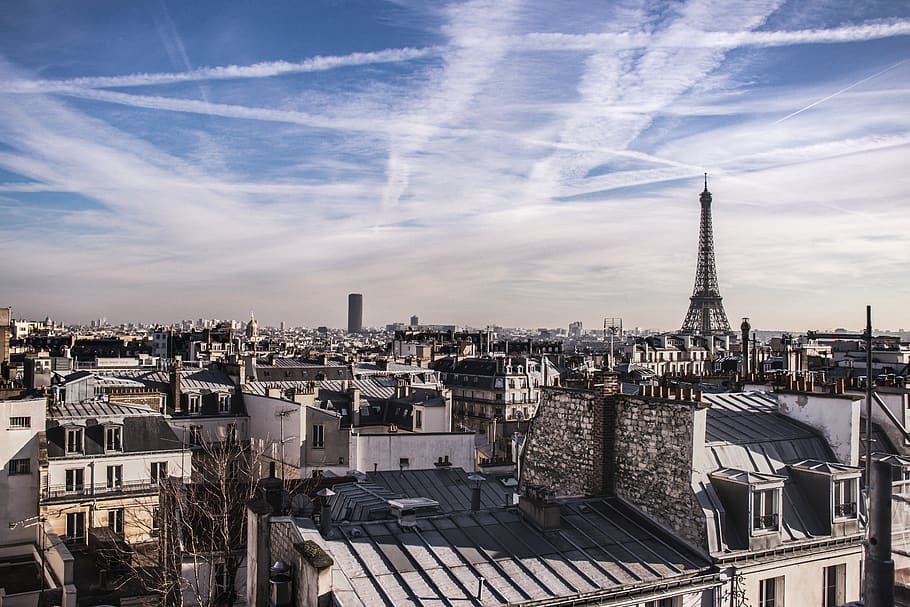

In [120]:
display(Image(content_path))

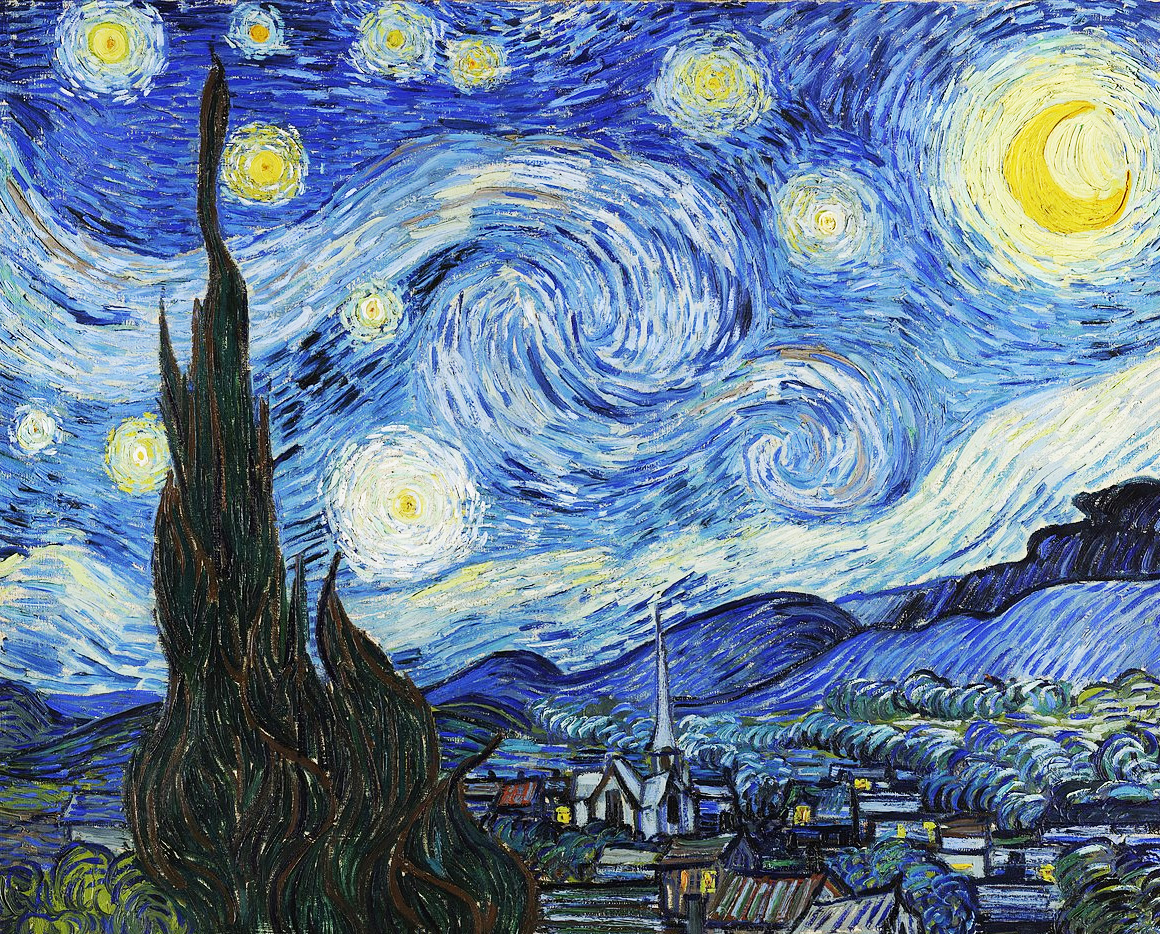

In [121]:
display(Image(style_path))

## Utils for the images
1. load_image - a function that loads image from the paths
2. imshow - a fuction to plot the image, when given a tensor

In [122]:
def load_img(path_to_img):
  '''
  This function helps load the image from the path
  inputs:
    path_to_img = The path of the image
  outputs:
    the image itself in form of tf.tensor
  '''
  # Open the file, reads content as string
  img = tf.io.read_file(path_to_img)
  # Decode image, (0 to 1)
  img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
  # Resizing image
  img = tf.image.resize(img, (224,224))
  # Expand dimension for the model (batch, h,w,c)
  img = tf.expand_dims(img,0)
  return img

def imshow(image, title=None):
  '''
  This function helps in visualizing the image
  inputs:
    image - Tensor
    title - The title of the plot
  '''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

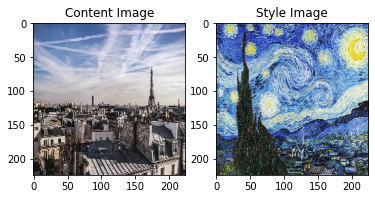

In [123]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')


# Models
We will use the `VGG19` model.

And also make intermediate models for our convenience.

In [124]:
vgg = tf.keras.applications.VGG19(include_top=False)
vgg.trainable = False
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [125]:
LAYERS =  [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1']

vgg_models = list()
for layer_name in LAYERS:
  layer_output = vgg.get_layer(layer_name).output
  vgg_models.append(
      tf.keras.models.Model(inputs=vgg.input,outputs=layer_output)
  )

# Content Representations
From embeddings, get me the picture

In [126]:
def compute_content_cost(model, content_image, generated_image):
  '''
  inputs:
    model
    content_image - content image
    generated_image - white noise
  outputs:
    The content loss
  '''

  pre_C = content_image*255.0
  pre_C = tf.keras.applications.vgg19.preprocess_input(pre_C)
  act_C = model(pre_C)
  m, n_h, n_w, n_c = act_C.get_shape().as_list()

  pre_G = generated_image*255.0
  pre_G = tf.keras.applications.vgg19.preprocess_input(pre_G)
  act_G = model(pre_G)

  J_content = tf.reduce_sum(tf.square(act_C - act_G))/(2 * n_h * n_w * n_c)
  return J_content

In [127]:
# Test
idx = 1
white_noise = np.random.normal(size = (1,224,224,3), loc = 0.5, scale = 0.1)

compute_content_cost(vgg_models[idx], content_image, white_noise)

<tf.Tensor: shape=(), dtype=float32, numpy=31397.844>

In [128]:
@tf.function()
def train_step(model, content_image, white_noise):
  with tf.GradientTape() as tape:
    content_loss = compute_content_cost(model, content_image, white_noise)
  grad = tape.gradient(content_loss,white_noise)
  opt.apply_gradients([(grad, white_noise)])
  white_noise.assign(tf.clip_by_value(white_noise, clip_value_min=0.0, clip_value_max=1.0))

100%|██████████| 100/100 [00:03<00:00, 30.00it/s]


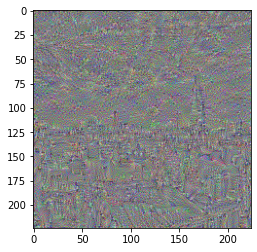

In [129]:
# Test
idx = 4
c = tf.constant(content_image)
w = tf.Variable(np.random.normal(size = (1,224,224,3), loc = 0.5, scale = 0.1))
opt = tf.keras.optimizers.Adam()
for i in tqdm(range(100)):
  train_step(vgg_models[idx], c, w)
imshow(w)

# Style Representations

In [130]:
def gram_matrix(input_tensor):
  '''
  inputs:
    inputs_tensor - Input Tensor
  outputs:
    Gram matrix of the tensor
  '''
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  return result

In [131]:
def compute_layer_style_cost(act_Style, act_Gen):
  '''
  inputs:
  act_Style - activation Style
  act_Gen - activation Generate
  outputs:
  The gram loss
  '''
  m, n_h, n_w, n_c = act_Gen.get_shape().as_list()

  # a_S_unrolled = tf.reshape(act_Style, [n_h*n_w, n_c])
  # a_G_unrolled = tf.reshape(act_Gen, [n_h*n_w, n_c])

  GS = gram_matrix(act_Style)
  GG = gram_matrix(act_Gen)

  J_style_layer = tf.reduce_sum(tf.square(GS-GG))/((2 * n_c * n_w * n_h)**2)
  return J_style_layer

In [132]:
def compute_style_cost(vgg_models, STYLE_LAYERS, style_image, generated_image):
  '''
  inputs:
    vgg_model - Intermediate VGG MODEL
    STYLE_LAYERS - The style layer
    gen_image - the generated image
  '''

  J_style = 0
  for idx, (layer_name, coeff) in enumerate(STYLE_LAYERS):
    pre_G = generated_image*255.0
    pre_G = tf.keras.applications.vgg19.preprocess_input(pre_G)
    act_G = vgg_models[idx](pre_G)

    pre_S = style_image*255.0
    pre_S = tf.keras.applications.vgg19.preprocess_input(pre_S)
    act_S = vgg_models[idx](pre_S)

    J_style_layer = compute_layer_style_cost(act_S, act_G)

    J_style += coeff * J_style_layer

  return J_style

In [133]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [134]:
# Test
white_noise = np.random.normal(size = (1,224,224,3), loc = 0.5, scale = 0.1)

compute_style_cost(vgg_models, STYLE_LAYERS, style_image, white_noise)

<tf.Tensor: shape=(), dtype=float32, numpy=32960555000.0>

In [135]:
@tf.function()
def train_step(vgg_models, STYLE_LAYERS, style_image, white_noise):
  with tf.GradientTape() as tape:
    style_loss = compute_style_cost(vgg_models, STYLE_LAYERS, style_image, white_noise)
  grad = tape.gradient(style_loss,white_noise)
  opt.apply_gradients([(grad, white_noise)])
  white_noise.assign(tf.clip_by_value(white_noise, clip_value_min=0.0, clip_value_max=1.0))

In [136]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

100%|██████████| 900/900 [00:57<00:00, 15.75it/s]


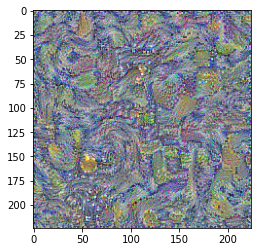

In [137]:
# Test
s = tf.constant(style_image)
w = tf.Variable(np.random.normal(size = (1,224,224,3), loc = 0.5, scale = 0.1))
opt = tf.keras.optimizers.Adam()
for i in tqdm(range(900)):
  train_step(vgg_models, STYLE_LAYERS, s, w)
imshow(w)

# Extracts the content and style loss

In [138]:
def extract(vgg_models, content_image, style_image, generated_image, content_layer_idx, STYLE_LAYERS):
  '''
  inputs:
    vgg_models - The vgg_models that are made
    content_image - The content image
    style_image - The style image
    generated_image - The noise image
    content_layer_idx - The idx of layer to use
    STYLE_LAYERS - The style layers with coeffs
  output:
    the content loss and style loss
  '''
  J_content = compute_content_cost(vgg_models[content_layer_idx], content_image, generated_image)
  J_style = compute_style_cost(vgg_models, STYLE_LAYERS, style_image, generated_image)

  return [J_content, J_style]

In [139]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
  '''
  computes the total loss
  '''
  J = alpha * J_content + beta * J_style
  return J

In [167]:
@tf.function()
def train_step(vgg_models,
               content_image,
               style_image,
               generated_image,
               content_layer_idx,
               STYLE_LAYERS,
               alpha,
               beta):
  with tf.GradientTape() as tape:
    J_c, J_s = extract(vgg_models,
                       content_image,
                       style_image,
                       generated_image,
                       content_layer_idx,
                       STYLE_LAYERS)
    loss = total_cost(J_c, J_s, alpha, beta)
  grad = tape.gradient(loss,generated_image)
  opt.apply_gradients([(grad, generated_image)])
  generated_image.assign(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))

In [ ]:
# Test
c = tf.constant(content_image)
s = tf.constant(style_image)
# w = tf.Variable(content_image)
w = tf.Variable(np.random.normal(size = (1,224,224,3), loc = 0.5, scale = 0.1))
opt = tf.keras.optimizers.Adam()
for i in tqdm(range(3000)):
  train_step(vgg_models,c,s,w,3,STYLE_LAYERS,alpha=10,beta=40)
imshow(w)

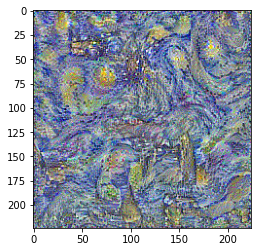

In [169]:
imshow(w)